# Calibration Tutorial - Crane, OR - Irrigated Flux Plot

## Step 1: Getting the Data

Note: Step 1 can be bypassed if necessary. Just unzip `tutorials/3_Crane/data/prepped_input.zip` and proceed to Step 2.

This tutorial is going to focus on calibrating the SWIM for a single unirrigated plot, which is a 150 meter buffer around FluxNet's US-Fpe eddy covariance station. This will be interesting because the flux station has independent observations of both meteorology and the ET flux itself. Let's see if we can improve upon our *a priori* estimates of soil hydraulic parameters and our default parameterization of the snow and Kcb model (function of NDVI).

This notebook bases all it's work on the polygons in `tutorials/3_Crane/data/gis/flux_fields.shp`.

This notebook is easily modified to get all the flux station's input data; just remove the `select` or like arguments (`field_select`/`target_fields`, etc.) so it doesn't run on only our focus, the station at Crane. This would additionally require downloading the entire bias correction GeoTIFF data set, from the Earth Engine asset folder `projects/ee-dgketchum/assets/swim/gridmet_bias_correction`.

We won't cover the details of compiling data for the modeling run unless it is a different approach than what we did in the first tutorial, `1_Boulder`. Revisit that tutorial's steps 2-4 for further explanation of what we speed through below. Let's get started:

In [1]:
import os
import sys
import json

import geopandas as gpd

root = os.path.abspath('../../..')
sys.path.append(root)

from swimrs.data_extraction.ee.ee_utils import is_authorized
from swimrs.data_extraction.ee.etf_export import sparse_sample_etf
from swimrs.data_extraction.ee.ndvi_export import sparse_sample_ndvi
from swimrs.data_extraction.ee.snodas_export import sample_snodas_swe
from swimrs.data_extraction.snodas.snodas import create_timeseries_json
from swimrs.data_extraction.ee.ee_props import get_irrigation, get_ssurgo, get_landcover

from swimrs.utils.google_bucket import list_and_copy_gcs_bucket

from swimrs.data_extraction.gridmet.gridmet import assign_gridmet_and_corrections
from swimrs.data_extraction.gridmet.gridmet import download_gridmet

from swimrs.prep.field_properties import write_field_properties
from swimrs.prep.remote_sensing import sparse_time_series, join_remote_sensing
from swimrs.prep.dynamics import process_dynamics_batch

from swimrs.prep.field_timeseries import join_daily_timeseries
from swimrs.prep.prep_plots import prep_fields_json

# Set matplotlib to display inline
%matplotlib inline

home = os.path.expanduser('~')
command = os.path.join(home, 'google-cloud-sdk/bin/gsutil')
# Export destination switch
drive = True  # default: export to Google Drive
# To use a Cloud Storage bucket instead (faster), uncomment and set your bucket:
# drive = False
bucket = 'your-bucket-name'
bucket = None if 'bucket' not in globals() else bucket
export_dest = 'drive' if drive else 'bucket'
export_bucket = None if drive else bucket

data = os.path.join(root, 'examples', '3_Crane', 'data')
shapefile_path = os.path.join(data, 'gis', 'flux_fields.shp')
gdf = gpd.read_file(shapefile_path)
gdf.shape

FEATURE_ID = 'field_1'


DataSourceError: /home/dgketchum/code/swim-rs/examples/3_Crane/data/gis/flux_fields.shp: No such file or directory

We will use our configuration file to instantiate a `ProjectConfig` object that holds all configuration details, including paths. This will simplify our lives:

In [ ]:
root = os.path.abspath('../../..')
project_ws = os.path.join(root, 'examples', '3_Crane')
data = os.path.join(project_ws, 'data')
config_path = os.path.join(project_ws, '3_Crane.toml')

config = ProjectConfig()
config.read_config(config_path, project_ws)

In [26]:
gdf.columns

Index(['field_1', 'field_2', 'field_3', 'field_4', 'field_5', 'field_6',
       'field_7', 'field_8', 'field_9', 'field_10', 'field_11', 'field_12',
       'field_13', 'field_14', 'AmeriFlux', 'field_16', 'field_17', 'field_18',
       'field_19', 'field_20', 'LAT', 'LON', 'FID', 'geometry'],
      dtype='object')

The shapefile is derived from John Volk's work, which is documented here: https://www.sciencedirect.com/science/article/pii/S0168192323000011

Their paper used a sophisticated method for determining the area on the ground that contibutes to the flux observation. Instead of using their footprints, we're going to use a 150-m buffer around the station for simplicity. We're just going to use one station from the dataset, US-FPe.

In [27]:
FEATURE_ID = config.field_index
gdf.index = gdf[FEATURE_ID]
selected_feature = 'S2'
gdf = gdf.loc[[selected_feature]].copy()
gdf

,field_1,field_2,field_3,field_4,field_5,field_6,field_7,field_8,field_9,field_10,...,AmeriFlux,field_16,field_17,field_18,field_19,field_20,LAT,LON,FID,geometry
field_1,,,,,,,,,,,,,,,,,,,,,
S2,S2,Croplands,OR,DRI,09/2017-04/2021,0.80,43.41712,-118.61424,1255.0,Alfalfa,...,None,None,None,None,None,None,43.417,-118.614,S2,"POLYGON ((-1805399.061 2485128.673, -1805406.4..."


In [28]:
centroid = gdf.geometry.centroid
x, y = centroid.x, centroid.y

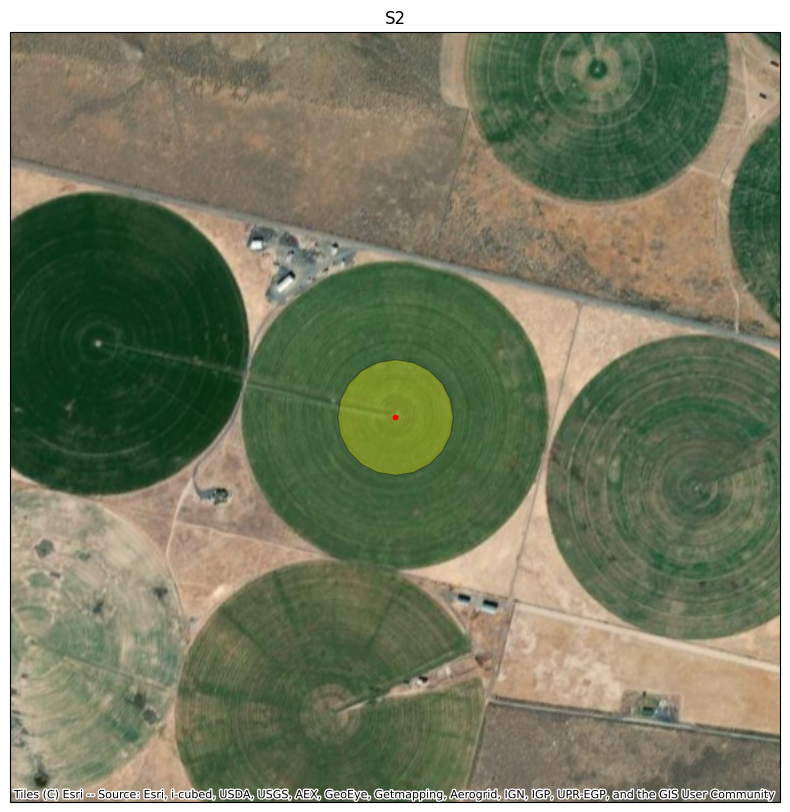

In [29]:
import contextily as ctx
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.epsg(5071)})

gdf.plot(ax=ax,
         edgecolor='black',
         facecolor='yellow',
         alpha=0.3,
         legend=True,
         transform=ccrs.epsg(5071))

gdf.geometry.centroid.plot(ax=ax, markersize=10, color='red', transform=ccrs.epsg(5071))

# Set the extent (x0, x1, y0, y1) to "zoom out"
ax.set_extent([x - 1000, x + 1000, y - 1000, y + 1000], crs=ccrs.epsg(5071))
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=ccrs.epsg(5071))

plt.title(selected_feature)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


Instead of using the `clustered_sample_etf` like in the first tutorial, we're going to use `sparse_sample_etf` since we only have one station. We would use the same if we selected from more stations, as they are spread out. The`sparse_sample_etf` function accepts a shapefile.

We can use the `select` argument and use a list of our single feature ID to only export that data. 

Note: In this tutorial, you can modify the function calls to export data for all the flux stations easily; just remove the `select` arguments, and it will get all the data needed for the validation tutorial.

### 1. Earth Engine Remote Sensing Extracts

In [30]:
landsat = os.path.join(config.data_dir, 'landsat')
extracts = os.path.join(landsat, 'extracts')
tables = os.path.join(landsat, 'tables')
if not os.path.isdir(tables):
    os.makedirs(tables, exist_ok=True)

In [14]:
# The extraction
is_authorized()
bucket = 'wudr'

for src in ['ndvi', 'etf']:
    for mask in ['inv_irr', 'irr']:
        
        dst = os.path.join(config.data_dir, 'landsat', src, mask)
        
        if not os.path.exists(dst):
            os.makedirs(dst, exist_ok=True)

        if src == 'etf':
            print(src, mask)
            sparse_sample_etf(shapefile_path, bucket=export_bucket, debug=False, mask_type=mask, check_dir=dst, dest=export_dest, drive_folder='swim', drive_categorize=True,                               start_yr=1987, end_yr=2022, feature_id=FEATURE_ID, select=[selected_feature])
        if src == 'ndvi':
            print(src, mask)
            sparse_sample_ndvi(shapefile_path, bucket=export_bucket, debug=False, mask_type=mask, check_dir=dst, dest=export_dest, drive_folder='swim', drive_categorize=True,                                start_yr=1987, end_yr=2022, feature_id=FEATURE_ID, select=[selected_feature])


Authorized
ndvi inv_irr
ndvi_S2_inv_irr_1987
ndvi_S2_inv_irr_1988
ndvi_S2_inv_irr_1989
ndvi_S2_inv_irr_1990
ndvi_S2_inv_irr_1991
ndvi_S2_inv_irr_1992
ndvi_S2_inv_irr_1993
ndvi_S2_inv_irr_1994
ndvi_S2_inv_irr_1995
ndvi_S2_inv_irr_1996
ndvi_S2_inv_irr_1997
ndvi_S2_inv_irr_1998
ndvi_S2_inv_irr_1999
ndvi_S2_inv_irr_2000
ndvi_S2_inv_irr_2001
ndvi_S2_inv_irr_2002
ndvi_S2_inv_irr_2003
ndvi_S2_inv_irr_2004
ndvi_S2_inv_irr_2005
ndvi_S2_inv_irr_2006
ndvi_S2_inv_irr_2007
ndvi_S2_inv_irr_2008
ndvi_S2_inv_irr_2009
ndvi_S2_inv_irr_2010
ndvi_S2_inv_irr_2011
ndvi_S2_inv_irr_2012
ndvi_S2_inv_irr_2013
ndvi_S2_inv_irr_2014
ndvi_S2_inv_irr_2015
ndvi_S2_inv_irr_2016
ndvi_S2_inv_irr_2017
ndvi_S2_inv_irr_2018
ndvi_S2_inv_irr_2019
ndvi_S2_inv_irr_2020
ndvi_S2_inv_irr_2021
ndvi_S2_inv_irr_2022
ndvi irr
ndvi_S2_irr_1987
ndvi_S2_irr_1988
ndvi_S2_irr_1989
ndvi_S2_irr_1990
ndvi_S2_irr_1991
ndvi_S2_irr_1992
ndvi_S2_irr_1993
ndvi_S2_irr_1994
ndvi_S2_irr_1995
ndvi_S2_irr_1996
ndvi_S2_irr_1997
ndvi_S2_irr_1998
ndvi_S2

In [32]:
# Copy to local directory; Note the flux-station specific for-loop

# use the following for a full station network extract:
# stations = gdf[FEATURE_ID].tolist()

# # use this for just Crane
stations = [selected_feature]

for src in ['ndvi', 'etf']:
    for mask in ['inv_irr', 'irr']:
        for station in stations:
            dst = os.path.join(config.data_dir, 'landsat', 'extracts', src, mask)
            if not os.path.isdir(dst):
                os.makedirs(dst, exist_ok=True)
            glob_ = f'{src}_{station}_{mask}'
            if not drive and export_bucket:
                list_and_copy_gcs_bucket(command, export_bucket, dst, glob=glob_, dry_run=False, overwrite=False)
            else:
                print('Drive exports: download the CSVs from Drive into', dst)

/home/dgketchum/PycharmProjects/swim-rs/tutorials/3_Crane/data/landsat/extracts/ndvi/inv_irr/ndvi_S2_inv_irr_1987.csv exists, skipping
/home/dgketchum/PycharmProjects/swim-rs/tutorials/3_Crane/data/landsat/extracts/ndvi/inv_irr/ndvi_S2_inv_irr_1988.csv exists, skipping
/home/dgketchum/PycharmProjects/swim-rs/tutorials/3_Crane/data/landsat/extracts/ndvi/inv_irr/ndvi_S2_inv_irr_1989.csv exists, skipping
Copying gs://wudr/ndvi_S2_inv_irr_1990.csv: Copying gs://wudr/ndvi_S2_inv_irr_1990.csv...
/ [1 files][  364.0 B/  364.0 B]                                                
Operation completed over 1 objects/364.0 B.                                      

Copied gs://wudr/ndvi_S2_inv_irr_1990.csv to /home/dgketchum/PycharmProjects/swim-rs/tutorials/3_Crane/data/landsat/extracts/ndvi/inv_irr
Copying gs://wudr/ndvi_S2_inv_irr_1991.csv: Copying gs://wudr/ndvi_S2_inv_irr_1991.csv...
/ [1 files][  487.0 B/  487.0 B]                                                
Operation completed over 1 objec

In [33]:
# Write to interpolated time series
  
types_ = ['inv_irr', 'irr']
sensing_params = ['ndvi', 'etf']

for mask_type in types_:

    for sensing_param in sensing_params:
        
        yrs = [x for x in range(1987, 2024)]

        ee_data, src = None, None

        ee_data = os.path.join(extracts, sensing_param, mask_type)
        src_pqt = os.path.join(tables, f'{sensing_param}_{mask_type}.parquet')

        algorithm = 'ssebop' if sensing_param == 'etf' else 'none'
        sparse_time_series(shapefile_path, ee_data, yrs, src_pqt, feature_id=FEATURE_ID, instrument='landsat', parameter=sensing_param, algorithm=algorithm, mask=mask_type, select=[selected_feature])

/home/dgketchum/PycharmProjects/swim-rs/tutorials/3_Crane/data/landsat/extracts/ndvi/inv_irr
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
/home/dgketchum/PycharmProjects/swim-rs/tutorials/3_Crane/data/landsat/extracts/etf/inv_irr
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
/home/dgketchum/PycharmProjects/swim-rs/tutorials/3_Crane/data/landsat/extracts/ndvi/irr
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
/home/dgketchum/PycharmProjects/swim-rs/tutorials/3_Crane/data/landsat/extracts/etf/irr
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
200

In [64]:
remote_sensing_tables_dir = config.remote_sensing_tables_dir
os.makedirs(remote_sensing_tables_dir, exist_ok=True)
rs_files = [os.path.join(tables, f) for f in os.listdir(tables) if f.endswith('.parquet')]
join_remote_sensing(rs_files, remote_sensing_tables_dir, station_selection='inclusive')

etf_inv_irr_ct
ndvi_inv_irr_ct
etf_inv_irr
etf_irr_ct
ndvi_irr
etf_irr
etf_irr_ct
ndvi_irr_ct
ndvi_inv_irr
etf_irr
ndvi_irr_ct
ndvi_irr


### 2. Other Earth Engine Extracts

In [53]:
snow_dst = os.path.join(config.data_dir, 'snodas', 'extracts')
if not os.path.isdir(snow_dst):
    os.makedirs(snow_dst, exist_ok=True)
    
# Use local shapefile (no EE asset upload required)
shapefile_path = os.path.join(root, 'examples', '3_Crane', 'data', 'gis', 'flux_fields.shp')
sample_snodas_swe(shapefile_path, bucket=export_bucket, debug=False, check_dir=snow_dst, overwrite=False, feature_id=FEATURE_ID, dest=export_dest, drive_folder='swim', drive_categorize=True)

swe_2004_01 exists, skipping
swe_2004_02 exists, skipping
swe_2004_03 exists, skipping
swe_2004_04 exists, skipping
swe_2004_05 exists, skipping
swe_2004_06 exists, skipping
swe_2004_07 exists, skipping
swe_2004_08 exists, skipping
swe_2004_09 exists, skipping
swe_2004_10 exists, skipping
swe_2004_11 exists, skipping
swe_2004_12 exists, skipping
swe_2005_01 exists, skipping
swe_2005_02 exists, skipping
swe_2005_03 exists, skipping
swe_2005_04 exists, skipping
swe_2005_05 exists, skipping
swe_2005_06 exists, skipping
swe_2005_07 exists, skipping
swe_2005_08 exists, skipping
swe_2005_09 exists, skipping
swe_2005_10 exists, skipping
swe_2005_11 exists, skipping
swe_2005_12 exists, skipping
swe_2006_01 exists, skipping
swe_2006_02 exists, skipping
swe_2006_03 exists, skipping
swe_2006_04 exists, skipping
swe_2006_05 exists, skipping
swe_2006_06 exists, skipping
swe_2006_07 exists, skipping
swe_2006_08 exists, skipping
swe_2006_09 exists, skipping
swe_2006_10 exists, skipping
swe_2006_11 ex

In [20]:
description = 'calibration_irr'
get_irrigation(shapefile_path, description, debug=False, selector=FEATURE_ID, lanid=True, dest=export_dest, drive_folder='swim', drive_categorize=True)

description = 'calibration_ssurgo'
get_ssurgo(shapefile_path, description, debug=False, selector=FEATURE_ID, dest=export_dest, drive_folder='swim', drive_categorize=True)

description = 'calibration_landcover'
get_landcover(shapefile_path, description, debug=False, selector=FEATURE_ID, dest=export_dest, drive_folder='swim', drive_categorize=True)

swe_2004_01
swe_2004_02
swe_2004_03
swe_2004_04
swe_2004_05
swe_2004_06
swe_2004_07
swe_2004_08
swe_2004_09
swe_2004_10
swe_2004_11
swe_2004_12
swe_2005_01
swe_2005_02
swe_2005_03
swe_2005_04
swe_2005_05
swe_2005_06
swe_2005_07
swe_2005_08
swe_2005_09
swe_2005_10
swe_2005_11
swe_2005_12
swe_2006_01
swe_2006_02
swe_2006_03
swe_2006_04
swe_2006_05
swe_2006_06
swe_2006_07
swe_2006_08
swe_2006_09
swe_2006_10
swe_2006_11
swe_2006_12
swe_2007_01
swe_2007_02
swe_2007_03
swe_2007_04
swe_2007_05
swe_2007_06
swe_2007_07
swe_2007_08
swe_2007_09
swe_2007_10
swe_2007_11
swe_2007_12
swe_2008_01
swe_2008_02
swe_2008_03
swe_2008_04
swe_2008_05
swe_2008_06
swe_2008_07
swe_2008_08
swe_2008_09
swe_2008_10
swe_2008_11
swe_2008_12
swe_2009_01
swe_2009_02
swe_2009_03
swe_2009_04
swe_2009_05
swe_2009_06
swe_2009_07
swe_2009_08
swe_2009_09
swe_2009_10
swe_2009_11
swe_2009_12
swe_2010_01
swe_2010_02
swe_2010_03
swe_2010_04
swe_2010_05
swe_2010_06
swe_2010_07
swe_2010_08
swe_2010_09
swe_2010_10
swe_2010_11
swe_

In [21]:
glob_ = 'swe'
if not drive and export_bucket:
    list_and_copy_gcs_bucket(command, export_bucket, snow_dst, glob=glob_, dry_run=False, overwrite=False)
else:
    print('Drive exports: download SNODAS CSVs from Drive into', snow_dst)

Copying gs://wudr/swe_2004_01.csv: Copying gs://wudr/swe_2004_01.csv...
/ [1 files][ 41.0 KiB/ 41.0 KiB]                                                
Operation completed over 1 objects/41.0 KiB.                                     

Copied gs://wudr/swe_2004_01.csv to /home/dgketchum/PycharmProjects/swim-rs/tutorials/3_Crane/data/snodas/extracts
Copying gs://wudr/swe_2004_02.csv: Copying gs://wudr/swe_2004_02.csv...
/ [1 files][ 39.1 KiB/ 39.1 KiB]                                                
Operation completed over 1 objects/39.1 KiB.                                     

Copied gs://wudr/swe_2004_02.csv to /home/dgketchum/PycharmProjects/swim-rs/tutorials/3_Crane/data/snodas/extracts
Copying gs://wudr/swe_2004_03.csv: Copying gs://wudr/swe_2004_03.csv...
/ [1 files][ 27.6 KiB/ 27.6 KiB]                                                
Operation completed over 1 objects/27.6 KiB.                                     

Copied gs://wudr/swe_2004_03.csv to /home/dgketchum/PycharmPro

NameError: name 'snow_out' is not defined

In [54]:
snow =  os.path.join(config.data_dir, 'snodas', 'snodas.json')
create_timeseries_json(snow_dst, snow, feature_id=FEATURE_ID)

Processing CSV files: 100%|██████████████████| 240/240 [00:01<00:00, 130.83it/s]


wrote /home/dgketchum/PycharmProjects/swim-rs/tutorials/3_Crane/data/snodas/snodas.json


In [22]:
description = 'calibration_ssurgo'
dst = os.path.join(config.data_dir, 'properties')
if not drive and export_bucket:
    list_and_copy_gcs_bucket(command, export_bucket, dst, glob=description, dry_run=False, overwrite=False)
else:
    print('Drive exports: download irrigation CSV(s) from Drive into', dst)

Copying gs://wudr/calibration_ssurgo.csv: Copying gs://wudr/calibration_ssurgo.csv...
/ [1 files][ 13.8 KiB/ 13.8 KiB]                                                
Operation completed over 1 objects/13.8 KiB.                                     

Copied gs://wudr/calibration_ssurgo.csv to /home/dgketchum/PycharmProjects/swim-rs/tutorials/3_Crane/data/properties


In [23]:
description = 'calibration_irr'
dst = os.path.join(config.data_dir, 'properties')
if not drive and export_bucket:
    list_and_copy_gcs_bucket(command, export_bucket, dst, glob=description, dry_run=False, overwrite=False)
else:
    print('Drive exports: download SSURGO CSV(s) from Drive into', dst)

Copying gs://wudr/calibration_irr.csv: Copying gs://wudr/calibration_irr.csv...
/ [1 files][ 30.4 KiB/ 30.4 KiB]                                                
Operation completed over 1 objects/30.4 KiB.                                     

Copied gs://wudr/calibration_irr.csv to /home/dgketchum/PycharmProjects/swim-rs/tutorials/3_Crane/data/properties


In [37]:
irr = os.path.join(config.data_dir, 'properties', 'calibration_irr.csv')
ssurgo = os.path.join(config.data_dir, 'properties', 'calibration_ssurgo.csv')
lulc = os.path.join(config.data_dir, 'properties', 'calibration_landcover.csv')
properties_json = os.path.join(config.data_dir, 'properties', 'calibration_properties.json')

write_field_properties(shp=shapefile_path,
                       out_js=properties_json,
                       lulc=lulc,
                       irr=irr,
                       soils=ssurgo,
                       index_col=FEATURE_ID,
                       select=[selected_feature],
                       lulc_key='modis_lc',
                       **{'extra_lulc_key': 'glc10_lc'})

We can see the Crane location has never been irrigated, according to IrrMapper.

In [38]:
with open(properties_json, 'r') as f:
    properties_dict = json.load(f)
properties_dict[selected_feature]

{'irr': {'1987': 0.478813559322034,
  '1988': 0.0,
  '1989': 0.4797347089167283,
  '1990': 0.0,
  '1991': 0.0067059690493736,
  '1992': 0.3462048636698602,
  '1993': 0.7598747236551219,
  '1994': 0.0,
  '1995': 0.0067059690493736,
  '1996': 0.6436624907885043,
  '1997': 1.0,
  '1998': 1.0,
  '1999': 1.0,
  '2000': 1.0,
  '2001': 1.0,
  '2002': 1.0,
  '2003': 1.0,
  '2004': 1.0,
  '2005': 0.1387988209285188,
  '2006': 1.0,
  '2007': 1.0,
  '2008': 1.0,
  '2009': 1.0,
  '2010': 1.0,
  '2011': 1.0,
  '2012': 1.0,
  '2013': 1.0,
  '2014': 1.0,
  '2015': 1.0,
  '2016': 1.0,
  '2017': 1.0,
  '2018': 1.0,
  '2019': 1.0,
  '2020': 1.0,
  '2021': 1.0,
  '2022': 1.0,
  '2023': 1.0,
  '2024': 1.0},
 'awc': 0.1000000014901161,
 'ksat': 5.363800048828125,
 'clay': 24.399999618530277,
 'sand': 39.29999923706055,
 'area_sq_m': 69528.82373430512}

It looks like the Crane location has been irrigated since about 1996.

In [39]:
cuttings_json = os.path.join(landsat, 'calibration_cuttings.json')
# Update: use process_dynamics_batch on joined daily time series after it is built.
# This cell is left here for narrative continuity; run the dynamics step after
# the 'Join daily time series' section below using: 
# process_dynamics_batch(joined_timeseries, properties_json, cuttings_json, etf_target='ssebop', irr_threshold=0.1,
#                        select=[selected_feature], masks=('irr','inv_irr'), instruments=('landsat',),
#                        use_lulc=False, use_mask=True, lookback=5, num_workers=1)

Analyzing Irrigation: 100%|█████████████████| 161/161 [00:00<00:00, 1012.33it/s]

S2: 2023 has 730/1095 nan
wrote /home/dgketchum/PycharmProjects/swim-rs/tutorials/3_Crane/data/landsat/calibration_cuttings.json


### 3. Meteorology Data

Since we are analyzing scattered stations, we accept we will need a different GridMET time series for each station, so we won't save any time associating each field with indexed GridMET cells (like we did with the cluster of fields). Therefore instead of using `find_gridmet_points` as we did in the previous tutorial, we can use the faster `get_gridmet_corrections`, which outputs the same things: a shapefile with the `GFID`s and a `json` file that has each GFID monthly correction factor. The difference is that the `GFID` is just a sequence of integers. This is all we need to proceed with downloading and process the GridMET data.

This has the added benefit of removing the dependency on a vector representation of the GridMET grid, which requires downloading a raster, vectorizing it, and manipulating that shapefile, which is described in the docstring of `find_gridmet_points`.

If running extractions for the entire flux network, you will need to replace the bias correction GeoTIFF residing in this tutorial's `data` directory with the CONUS rasters from Earth Engine (`projects/ee-dgketchum/assets/swim/gridmet_bias_correction`). See https://developers.google.com/earth-engine/guides/exporting_images for tips on downloading.

Let's run the function to extract correction factors and download the data for Crane:

In [65]:
correction_tifs = os.path.join(config.data_dir, 'bias_correction_tif')

fields_gridmet = os.path.join(config.data_dir, 'gis', 'flux_fields_gfid.shp')

gridmet_factors = os.path.join(config.data_dir, 'gis', 'flux_fields_gfid.json')

met = config.met_dir
os.makedirs(met, exist_ok=True)

In [66]:
assign_gridmet_and_corrections(fields=shapefile_path,
                        gridmet_ras=correction_tifs,
                        fields_join=fields_gridmet,
                        factors_js=gridmet_factors,
                        feature_id=FEATURE_ID,
                        field_select=[selected_feature])

Find field-gridmet joins


Assigning GridMET IDs: 100%|█████████████████| 161/161 [00:00<00:00, 211.43it/s]

Writing 1 of 161 input features


In [45]:
download_gridmet(fields_gridmet, gridmet_factors, met, start='1987-01-01', end='2023-12-31',
                 overwrite=False, feature_id=FEATURE_ID, target_fields=[selected_feature])

gridmet_114.csv


### 4. Model Preparation

Now that we have out data together, the rest of the prep process is the same as in the first tutorial.

In [60]:
joined_timeseries = config.joined_timeseries_dir
os.makedirs(joined_timeseries, exist_ok=True)

In [67]:
params = ['etf_inv_irr',
          'ndvi_inv_irr',
          'etf_irr',
          'ndvi_irr']
params += ['{}_ct'.format(p) for p in params]

join_daily_timeseries(fields=fields_gridmet,
                      met_dir=met,
                      rs_dir=remote_sensing_tables_dir,
                      dst_dir=joined_timeseries,
                      snow=snow,
                      overwrite=True,
                      start_date='1987-01-01',
                      end_date='2022-12-31',
                      feature_id=FEATURE_ID,
                      **{'met_mapping': 'GFID',
                         'target_fields': [selected_feature]})
joined_timeseries

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.26s/it]

1 fields were successfully processed
0 fields were dropped due to missing data


'/home/dgketchum/PycharmProjects/swim-rs/tutorials/3_Crane/data/input_timeseries'

In [59]:
# Dynamics (irrigation windows, gw subsidy, K caps)
dynamics_json = config.dynamics_data_json
process_dynamics_batch(joined_timeseries,
                       properties_json,
                       dynamics_json,
                       etf_target='ssebop',
                       irr_threshold=config.irrigation_threshold,
                       select=[selected_feature],
                       masks=('irr', 'inv_irr'),
                       instruments=('landsat',),
                       use_lulc=False,
                       use_mask=True,
                       lookback=5,
                       num_workers=1)

# Build model input file
rs_params = [('none', 'ndvi', 'irr'),
             ('none', 'ndvi', 'inv_irr'),
             ('ssebop', 'etf', 'irr'),
             ('ssebop', 'etf', 'inv_irr')]

processed_targets, excluded_targets = prep_fields_json(properties_json,
                                                       joined_timeseries,
                                                       dynamics_json,
                                                       config.input_data,
                                                       target_plots=[selected_feature],
                                                       rs_params=rs_params,
                                                       interp_params=('ndvi',))

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


wrote /home/dgketchum/PycharmProjects/swim-rs/tutorials/3_Crane/data/prepped_input.json


Note: If you're just running the single station, the code will warn you're missing the other 160 stations. It's not a problem.

Hopefully, that went quick. In Step 2, we'll run an uncalibrated model.

### Retrieve ETf and NDVI from Google Drive

After exports finish in the Earth Engine task manager:
1) Open Google Drive. If `drive_categorize=True`:
   - ETf files under `swim_etf/` (e.g., `etf_irr_1987.csv`, `etf_inv_irr_1987.csv`)
   - NDVI files under `swim_ndvi/` (e.g., `ndvi_irr_1987.csv`, `ndvi_inv_irr_1987.csv`)
   Otherwise look under the `swim/` folder.
2) Create local extract folders:
   - `examples/3_Crane/data/landsat/extracts/etf/irr/` and `.../etf/inv_irr/`
   - `examples/3_Crane/data/landsat/extracts/ndvi/irr/` and `.../ndvi/inv_irr/`
3) Download Drive CSVs into those folders.
4) Verify the years in your study window are present for both masks before continuing.

Tip: If you have a Cloud Storage bucket and set `drive=False`:
- You can move files with `gsutil -m cp` or the helper `list_and_copy_gcs_bucket`.
- Bucket transfers are significantly faster for large projects.